<a href="https://colab.research.google.com/github/AlessandroSavelli/LAB_IA_SEMSEG_CD_23/blob/main/SEM%26SEG_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from random import shuffle
import torch
from torch import nn
import math
from glob import glob
import sys
import shutil

import albumentations as A

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


%matplotlib inline

In [98]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
torch.cuda.empty_cache()

In [100]:
import os
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
import cv2
from glob import glob
from scipy import ndimage
import pandas as pd

def collect_image_paths(directory):
    image_paths = []
    for root, dirs, files in os.walk(directory):
        dirs.sort()  # Ordina le sottocartelle in ordine alfabetico
        for file in sorted(files):  # Ordina i file in ordine alfabetico
            if file.endswith(".png"):
                file_path = os.path.join(root, file)
                image_paths.append((file, file_path))
    return image_paths

class segDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, mask_paths, training=True, transform=None):
        super(segDataset, self).__init__()
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.training = training  # Aggiungi questa linea per impostare l'attributo training

        self.RGB_classes = {
            'Impervious_Surface': [255, 0, 0],       # Rosso
            'Agriculture': [0, 255, 0],             # Verde
            'Forest_and_Other_Vegetation': [0, 0, 255],  # Blu
            'Wetlands': [255, 204, 0],             # Arancione
            'Soil': [45, 102, 85],                 # Ciano
            'Water': [51, 153, 255],               # Azzurro
            'Unknown': [255, 138, 253]            # Rosa
        }


    def __getitem__(self, idx):
        img_path = self.image_paths[idx][1]
        mask_path = self.mask_paths[idx][1]



        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        cls_mask=mask


        cls_mask = np.zeros((mask.shape[0], mask.shape[1]))
        cls_mask[(mask == self.RGB_classes['Impervious_Surface']).all(axis=2)] = 0
        cls_mask[(mask == self.RGB_classes['Agriculture']).all(axis=2)] = 1
        cls_mask[(mask == self.RGB_classes['Forest_and_Other_Vegetation']).all(axis=2)] = 2
        cls_mask[(mask == self.RGB_classes['Wetlands']).all(axis=2)] = 3
        cls_mask[(mask == self.RGB_classes['Soil']).all(axis=2)] = 4
        cls_mask[(mask == self.RGB_classes['Water']).all(axis=2)] = 5
        cls_mask[(mask == self.RGB_classes['Unknown']).all(axis=2)] = 6



        if self.training:
            if self.transform:
                image = transforms.functional.to_pil_image(image)
                image = self.transform(image)
                image = np.array(image)

            if np.random.rand() < 0.5:
                angle = np.random.randint(4) * 90
                image = ndimage.rotate(image, angle, reshape=True)
                cls_mask = ndimage.rotate(cls_mask, angle, reshape=True)

            if np.random.rand() < 0.5:
                image = np.flip(image, 0)
                cls_mask = np.flip(cls_mask, 0)

            if np.random.rand() < 0.5:
                image = np.flip(image, 1)
                cls_mask = np.flip(cls_mask, 1)

        image = cv2.resize(image, (512, 512)) / 255.0
        cls_mask = cv2.resize(cls_mask, (512, 512))
        image = np.moveaxis(image, -1, 0)

       #return torch.tensor(image).float(), torch.tensor(cls_mask, dtype=torch.int64)
        return torch.tensor(image).float(), torch.tensor(cls_mask, dtype=torch.int64)


    def __len__(self):
        return len(self.image_paths)

# Define the paths to image and mask directories
image_directory = "/content/drive/MyDrive/Colab Notebooks/sentinel2png_da_usare"
mask_directory = "/content/drive/MyDrive/Colab Notebooks/musk_png_da_usare"

# Collect image and mask paths
image_paths_list = collect_image_paths(image_directory)
mask_paths_list = collect_image_paths(mask_directory)

# Create the dataset
dataset = segDataset(image_paths_list, mask_paths_list, training=True)


In [101]:
from torch.utils.data import random_split

total_length = len(dataset)

# Calcola la lunghezza desiderata per il nuovo dataset ridotto
new_length = total_length // 3

# Crea due nuovi dataset, uno con la lunghezza desiderata e l'altro con il resto
dataset, discarded_dataset = random_split(dataset, [new_length, total_length - new_length])

In [102]:
len(dataset)

413

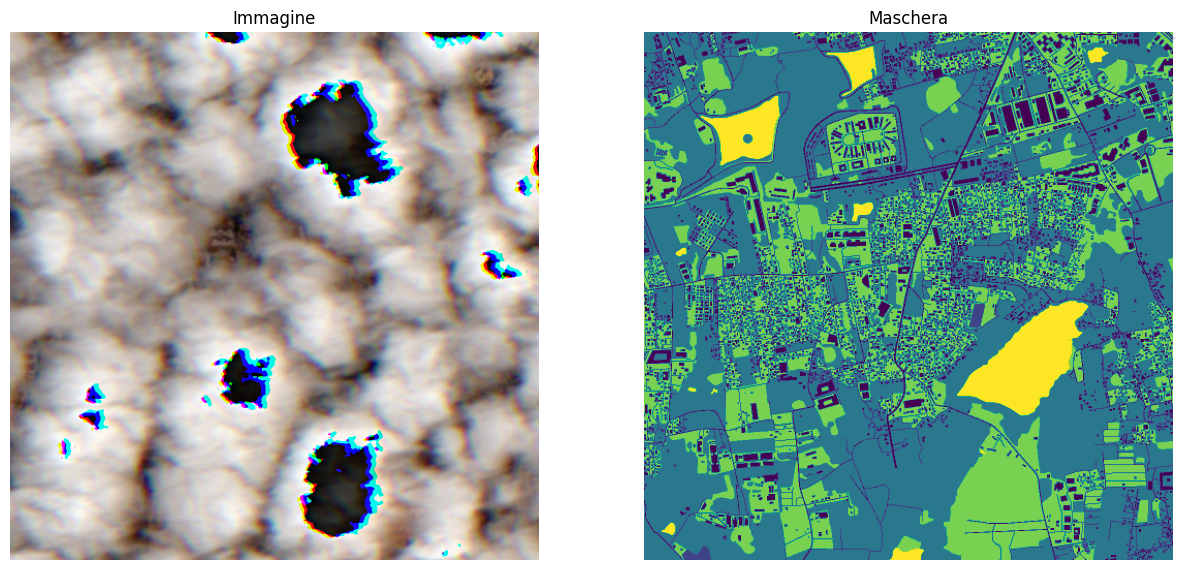

In [103]:
d = dataset[322]

plt.figure(figsize=(15, 15))

plt.subplot(1, 2, 1)
plt.imshow(np.moveaxis(d[0].numpy(), 0, -1))
plt.title("Immagine")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(d[1].numpy())
plt.title("Maschera")
plt.axis("off")

plt.show()

In [104]:
test_num = int(0.15 * len(dataset))
print(f'test data : {test_num}')
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset)-test_num, test_num], generator=torch.Generator().manual_seed(777))

test data : 61


In [105]:
BATCH_SIZE = 4
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)#4

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [106]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [107]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64) #64
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [108]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=-1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [109]:
criterion = FocalLoss(gamma=3/4).to(device)

In [110]:
class mIoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True, n_classes=9):
        super(mIoULoss, self).__init__()
        self.classes = n_classes

    def to_one_hot(self, tensor):
        n,h,w = tensor.size()
        one_hot = torch.zeros(n,self.classes,h,w).to(tensor.device).scatter_(1,tensor.view(n,1,h,w),1)
        return one_hot

    def forward(self, inputs, target):
        # inputs => N x Classes x H x W
        # target_oneHot => N x Classes x H x W

        N = inputs.size()[0]

        # predicted probabilities for each pixel along channel
        inputs = F.softmax(inputs,dim=1)

        # Numerator Product
        target_oneHot = self.to_one_hot(target)
        inter = inputs * target_oneHot
        ## Sum over all pixels N x C x H x W => N x C
        inter = inter.view(N,self.classes,-1).sum(2)

        #Denominator
        union= inputs + target_oneHot - (inputs*target_oneHot)
        ## Sum over all pixels N x C x H x W => N x C
        union = union.view(N,self.classes,-1).sum(2)

        loss = inter/union

        ## Return average loss over classes and batch
        return 1-loss.mean()

In [111]:
"""
def acc(label, predicted):
  seg_acc = (y.cpu() == torch.argmax(pred_mask, axis=1).cpu()).sum() / torch.numel(y.cpu())
  return seg_acc
"""
def acc(label, predicted):
    seg_acc = (label.cpu() == torch.argmax(predicted, axis=1).cpu()).sum() / torch.numel(label.cpu())
    return seg_acc

In [112]:
min_loss = torch.tensor(float('inf'))

model = UNet(n_channels=3, n_classes=7, bilinear=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

In [113]:
os.makedirs('./content/drive/MyDrive/Colab Notebooks/modello1_full', exist_ok=True)

N_EPOCHS = 20
N_DATA = len(train_dataset)
N_TEST = len(test_dataset)

plot_losses = []
plot_validation = []
scheduler_counter = 0

for epoch in range(N_EPOCHS):
  # training
  model.train()
  loss_list = []
  acc_list = []
  for batch_i, (x, y) in enumerate(train_dataloader):

      pred_mask = model(x.to(device))
      loss = criterion(pred_mask, y.to(device))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_list.append(loss.cpu().detach().numpy())
      acc_list.append(acc(y,pred_mask).numpy())

      sys.stdout.write(
          "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f)]"
          % (
              epoch,
              N_EPOCHS,
              batch_i,
              len(train_dataloader),
              loss.cpu().detach().numpy(),
              np.mean(loss_list),
          )
      )
  scheduler_counter += 1
  # testing
  model.eval()
  val_loss_list = []
  val_acc_list = []
  for batch_i, (x, y) in enumerate(test_dataloader):
      with torch.no_grad():
          pred_mask = model(x.to(device))
      val_loss = criterion(pred_mask, y.to(device))
      val_loss_list.append(val_loss.cpu().detach().numpy())
      val_acc_list.append(acc(y,pred_mask).numpy())

  print(' epoch {} - loss : {:.5f} - acc : {:.2f} - val loss : {:.5f} - val acc : {:.2f}'.format(epoch,
                                                                                                 np.mean(loss_list),
                                                                                                 np.mean(acc_list),
                                                                                                 np.mean(val_loss_list),
                                                                                                 np.mean(val_acc_list)))
  plot_losses.append([epoch, np.mean(loss_list), np.mean(val_loss_list)])
  plot_validation.append([epoch, np.mean(acc_list), np.mean(val_acc_list)])

  compare_loss = np.mean(val_loss_list)
  is_best = compare_loss < min_loss
  if is_best == True:
    scheduler_counter = 0
    min_loss = min(compare_loss, min_loss)
    #torch.save(model.state_dict(), './saved_models/unet_epoch_{}_{:.5f}.pt'.format(epoch,np.mean(val_loss_list)))
    #torch.save(model.state_dict(), './saved_models/unet_epoch_{}.pt'.format(epoch,np.mean(val_loss_list)))
    torch.save(model.state_dict(), './content/drive/MyDrive/Colab Notebooks/modello1_full/Unet_E_FULL.pt'.format(epoch,np.mean(val_loss_list)))

  if scheduler_counter > 5:
    lr_scheduler.step()
    print(f"lowering learning rate to {optimizer.param_groups[0]['lr']}")
    scheduler_counter = 0

[Epoch 0/20] [Batch 87/88] [Loss: 1.290290 (1.259900)] epoch 0 - loss : 1.25990 - acc : 0.49 - val loss : 1.09204 - val acc : 0.55
[Epoch 1/20] [Batch 87/88] [Loss: 1.174431 (1.148160)] epoch 1 - loss : 1.14816 - acc : 0.51 - val loss : 1.01304 - val acc : 0.55
[Epoch 2/20] [Batch 87/88] [Loss: 0.891694 (1.118963)] epoch 2 - loss : 1.11896 - acc : 0.52 - val loss : 0.98777 - val acc : 0.56
[Epoch 3/20] [Batch 87/88] [Loss: 1.133377 (1.106594)] epoch 3 - loss : 1.10659 - acc : 0.52 - val loss : 1.03203 - val acc : 0.55
[Epoch 4/20] [Batch 87/88] [Loss: 1.062025 (1.098467)] epoch 4 - loss : 1.09847 - acc : 0.53 - val loss : 1.01532 - val acc : 0.56
[Epoch 5/20] [Batch 87/88] [Loss: 1.037495 (1.089380)] epoch 5 - loss : 1.08938 - acc : 0.53 - val loss : 0.99461 - val acc : 0.55
[Epoch 6/20] [Batch 87/88] [Loss: 0.971872 (1.083710)] epoch 6 - loss : 1.08371 - acc : 0.52 - val loss : 1.01444 - val acc : 0.56
[Epoch 7/20] [Batch 87/88] [Loss: 1.024056 (1.067491)] epoch 7 - loss : 1.06749 - a

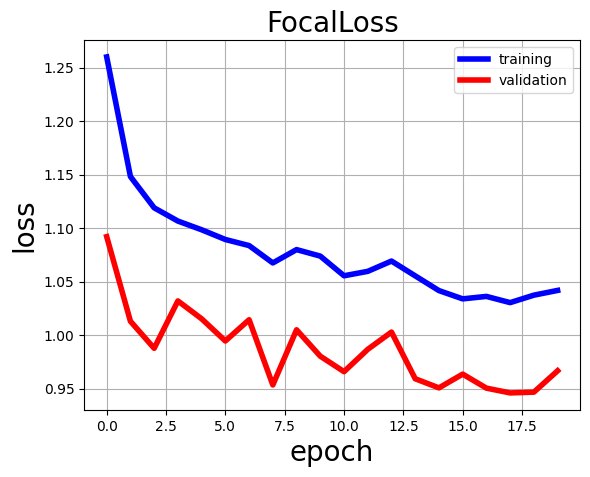

In [114]:
# plot loss
plot_losses = np.array(plot_losses)
plt.plot(plot_losses[:,0], plot_losses[:,1], color='b', linewidth=4)
plt.plot(plot_losses[:,0], plot_losses[:,2], color='r', linewidth=4)
plt.title('FocalLoss', fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.grid()
plt.legend(['training', 'validation']) # using a named size
plt.show()

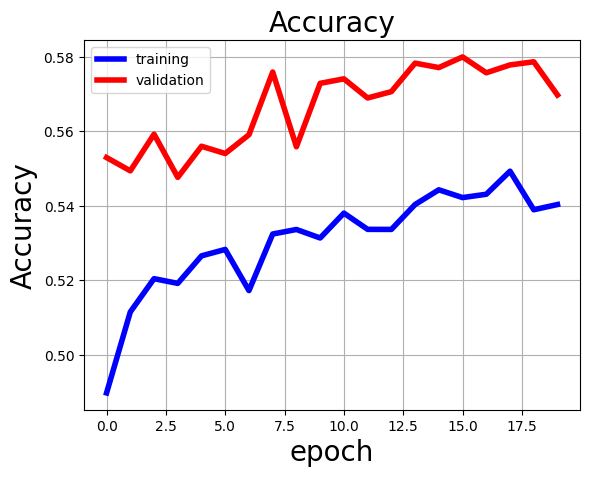

In [115]:
# plot accuracy
plot_validation = np.array(plot_validation)
plt.plot(plot_validation[:,0], plot_validation[:,1], color='b', linewidth=4)
plt.plot(plot_validation[:,0], plot_validation[:,2], color='r', linewidth=4)
plt.title('Accuracy', fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.grid()
plt.legend(['training', 'validation']) # using a named size
plt.show()

In [116]:
model.load_state_dict(torch.load('/content/saved_models/unet_epoch.pt'))

FileNotFoundError: ignored

In [ ]:
model.eval()
i = 0
for batch_i, (x, y) in enumerate(test_dataloader):
    for j in range(len(x)):
        result = model(x.to(device)[j:j+1])
        mask = torch.argmax(result, axis=1).cpu().detach().numpy()[0]
        im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        gt_mask = y[j]

        plt.figure(figsize=(12,12))

        plt.subplot(1,3,1)
        im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        plt.imshow(im)

        plt.subplot(1,3,2)
        plt.imshow(gt_mask)

        plt.subplot(1,3,3)
        plt.imshow(mask)
        #plt.show()
        plt.savefig('./content/drive/MyDrive/Colab Notebooks/modello1_full/Unet_E_FULL.pt'+str(i)+'.png')
        i+=1